In [1]:
import sys
import os
import requests
import datetime
from pathlib import Path
#
path_root = Path(os.path.abspath(''))
sys.path.insert(1, os.path.join(path_root))
#
path_root2 = Path(os.path.abspath('')).parent
sys.path.insert(1, os.path.join(path_root2))

import time
import talib
import sqlite3 as sqlite3
import numpy as np
import pandas as pd
import json
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
prop = fm.FontProperties(fname='DejaVuSansYuanTi-Regular.ttf')
from scipy import stats
from util.util import get_ucodes
from pypfopt import risk_models, expected_returns, efficient_frontier, plotting, objective_functions

path_sqlite = os.path.join(path_root, 'data', 'aastock', 'sqlite', 'hk-marketwatch.db')
if not os.path.exists(path_sqlite):
    path_sqlite = os.path.join(path_root2, 'data', 'aastock', 'sqlite', 'hk-marketwatch.db')

cur_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
temp_path = os.path.join(path_root, '現代資產組合', cur_time)
Path(temp_path).mkdir(parents=True, exist_ok=True)

pd.options.mode.chained_assignment = None

In [2]:
# 繪圖
def draw_table(data, title, scale_x=2, scale_y=1.5, is_show=False):
    ax = plt.subplot(111, frame_on=False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    table = pd.plotting.table(ax, data, loc='center')
    table.auto_set_column_width(col=list(range(len(data.columns))))
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(scale_x, scale_y)
    plt.savefig(os.path.join(temp_path, title), bbox_inches="tight")
    if not is_show:
        plt.clf()
    print(title)

In [3]:
conn = sqlite3.connect(path_sqlite)
cursor = conn.cursor()

data = {}
ucodes = ['hsi', 'hsce', 'ssec', 'ixic', 'sp500', 'n225', 'twii', 'ks11', 'gdaxi', 'fchi', 'ftse']
for ucode in ucodes:
    if '.HK' in ucode:
        ucode = ucode.replace('.HK', '').zfill(5)
    if '.SS' in ucode or '.SZ' in ucode:
        ucode = ucode.replace('.SS', '').replace('.SZ', '').zfill(6)
    
    #
    sql = """SELECT t.code, t.lot, t.nmll, t.stime, t.high, t.low, t.open, t.close, t.volume
                FROM (SELECT n.code, n.lot, n.nmll, c.stime, c.high, c.low, c.open, c.close, c.volume 
                    FROM s_{} AS c INNER JOIN name AS n 
                        ON c.code=n.code ORDER BY c.stime DESC) AS t 
                            ORDER BY t.stime """.format(ucode)
    cursor.execute(sql)
    columns = ['code', 'lot', 'nmll', 'sdate', 'high', 'low', 'open', 'last', 'vol']
    data[ucode] = pd.DataFrame(cursor.fetchall(), columns=columns)
    data[ucode].index = pd.to_datetime(data[ucode].sdate)
    print(f"{ucode}:   {data[ucode].index[0]} ~ {data[ucode].index[-1]}  {data[ucode].shape}")
conn.close()

hsi:   1986-12-31 00:00:00 ~ 2021-08-25 00:00:00  (8525, 9)
hsce:   1993-07-15 00:00:00 ~ 2021-08-25 00:00:00  (6888, 9)
ssec:   1992-05-08 00:00:00 ~ 2021-08-25 00:00:00  (7223, 9)
ixic:   1971-02-05 00:00:00 ~ 2021-08-25 00:00:00  (12391, 9)
sp500:   1927-12-30 00:00:00 ~ 2021-08-26 00:00:00  (19676, 9)
n225:   1965-01-05 00:00:00 ~ 2021-08-19 00:00:00  (13705, 9)
twii:   1990-01-04 00:00:00 ~ 2021-08-19 00:00:00  (7769, 9)
ks11:   1990-01-03 00:00:00 ~ 2021-08-19 00:00:00  (7798, 9)
gdaxi:   1987-12-30 00:00:00 ~ 2021-08-18 00:00:00  (8476, 9)
fchi:   1990-03-01 00:00:00 ~ 2021-08-18 00:00:00  (7980, 9)
ftse:   1984-01-03 00:00:00 ~ 2021-08-18 00:00:00  (9559, 9)


In [4]:
data_all = []
nmll = []
for k, df in data.items():
    data_all.append(df['last'])
    nmll.append(k)
df2 = pd.concat(data_all, axis=1)
df2 = df2.dropna()
df2.columns = nmll
print(f"{df2.index[0]} ~ {df2.index[-1]}  {df2.shape}")

1993-07-15 00:00:00 ~ 2021-08-17 00:00:00  (5743, 11)


In [5]:
start_year = list(dict.fromkeys(df2.index.year.values))[1]
end_year = list(dict.fromkeys(df2.index.year.values))[-1]

相關系數 1994年起
correlation_coefficient_2.png


,hsi,hsce,ssec,ixic,sp500,n225,twii,ks11,gdaxi,fchi,ftse
hsi,1.000000,0.865573,0.850532,0.754561,0.812634,0.343687,0.787462,0.922797,0.896557,0.649184,0.817641
hsce,0.865573,1.000000,0.806070,0.462075,0.510341,0.129874,0.566148,0.863120,0.630082,0.316517,0.517071
ssec,0.850532,0.806070,1.000000,0.587659,0.655169,0.161418,0.622204,0.758984,0.760908,0.648690,0.692381
ixic,0.754561,0.462075,0.587659,1.000000,0.980773,0.631078,0.898904,0.777224,0.907879,0.643438,0.690472
sp500,0.812634,0.510341,0.655169,0.980773,1.000000,0.575944,0.887152,0.801018,0.955515,0.719966,0.792206
n225,0.343687,0.129874,0.161418,0.631078,0.575944,1.000000,0.646249,0.368391,0.502580,0.303849,0.321262
twii,0.787462,0.566148,0.622204,0.898904,0.887152,0.646249,1.000000,0.789585,0.857981,0.596281,0.710709
ks11,0.922797,0.863120,0.758984,0.777224,0.801018,0.368391,0.789585,1.000000,0.854465,0.478233,0.672233
gdaxi,0.896557,0.630082,0.760908,0.907879,0.955515,0.502580,0.857981,0.854465,1.000000,0.756922,0.883912
fchi,0.649184,0.316517,0.648690,0.643438,0.719966,0.303849,0.596281,0.478233,0.756922,1.000000,0.855492


<Figure size 432x288 with 0 Axes>

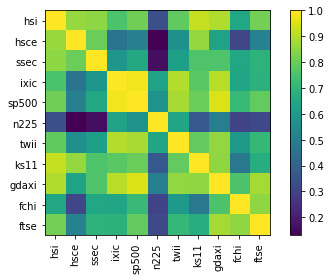

In [6]:
# 相關系數
print(f'相關系數 {start_year}年起')
draw_table(data=df2.corr().round(4), title='correlation_coefficient_2.png', scale_x=1.5, scale_y=1.5)
plotting.plot_covariance(df2.corr(), plot_correlation=False, filename=os.path.join(temp_path, 'correlation_coefficient_1.png'))
df2.corr()

均方差 1994年起      (5743, 11)
mean_square_error_2.png


,hsi,hsce,ssec,ixic,sp500,n225,twii,ks11,gdaxi,fchi,ftse
hsi,0.076295,0.078512,0.024574,0.019822,0.015518,0.035766,0.031975,0.038385,0.027164,0.027368,0.023567
hsce,0.078512,0.146879,0.035224,0.019366,0.015776,0.038568,0.035460,0.042708,0.026133,0.026625,0.024057
ssec,0.024574,0.035224,0.110858,0.004840,0.003451,0.013548,0.012894,0.013289,0.006838,0.007563,0.006117
ixic,0.019822,0.019366,0.004840,0.070353,0.048260,0.013558,0.013929,0.017668,0.038057,0.034399,0.026174
sp500,0.015518,0.015776,0.003451,0.048260,0.042429,0.011279,0.009954,0.013405,0.031864,0.029743,0.023801
n225,0.035766,0.038568,0.013548,0.013558,0.011279,0.063043,0.025637,0.033951,0.021882,0.022950,0.018452
twii,0.031975,0.035460,0.012894,0.013929,0.009954,0.025637,0.060739,0.031254,0.016420,0.016756,0.013811
ks11,0.038385,0.042708,0.013289,0.017668,0.013405,0.033951,0.031254,0.083444,0.022074,0.021403,0.018196
gdaxi,0.027164,0.026133,0.006838,0.038057,0.031864,0.021882,0.016420,0.022074,0.062867,0.054204,0.039224
fchi,0.027368,0.026625,0.007563,0.034399,0.029743,0.022950,0.016756,0.021403,0.054204,0.059150,0.040824


<Figure size 432x288 with 0 Axes>

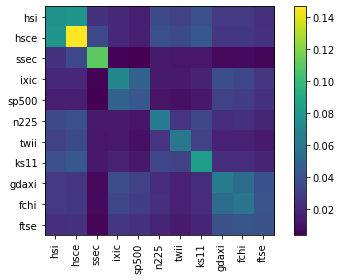

In [7]:
# 標準差
print(f'均方差 {start_year}年起      {df2.shape}')
draw_table(data=risk_models.sample_cov(df2).round(4), title='mean_square_error_2.png', scale_x=1.5, scale_y=1.5)
plotting.plot_covariance(risk_models.sample_cov(df2), plot_correlation=False, show_tickers=True, filename=os.path.join(temp_path, 'mean_square_error_1.png'))
risk_models.sample_cov(df2)

In [8]:
def simulate(df7):
    df7_1 = pd.DataFrame(columns=df7.columns)
    df7_1['Date'] = df7['Date']
    for v in df7.columns[1:]:
        cur_money = 10000
        no = 1
        for v1 in df7[v]:
            data2 = cur_money * (v1 / 100)
            cur_money = cur_money + data2
            df7_1.loc[no, v] = cur_money
            no = no + 1
    return df7_1

In [9]:
# inflation rate
cpi_data = {
    'hk': 'hk_cpi_1980',
    'china': 'china_cpi_1993',
    'us': 'us_cpi'
}
cpi = {}

for k, v in cpi_data.items():
    df8 = pd.read_csv(os.path.join(path_root, f'{v}.csv'))
    df8.Date = pd.to_datetime(df8.Date)
    df8.index = df8.Date
    df8.sort_index(inplace=True)
    
    #
    if k == 'china' or k == 'us':
        df8 = df8.groupby(df8['Date'].dt.year)['cpi'].agg(['sum', 'mean', 'max'])
        df8.columns = ['Date', 'cpi', 'max']
        del df8['max']
        df8.Date = [str(v2)+'-12-31' for v2 in df8.index.values]
    elif k == 'hk':
        df8.Date = df8.Date.dt.strftime('%Y-%m-%d')
    
    #
    no = 0
    for k1, v1 in df8.iterrows():
        if no < df8.shape[0] and no > 0:
            df8.loc[k1, 'Purchasing Power(%)'] = (df8.iloc[no-1].cpi - df8.iloc[no].cpi) / df8.iloc[no].cpi * 100
        no = no + 1
    df8['Inflation(%)'] = df8['cpi'].pct_change()*100
    df8.reset_index(drop=True, inplace=True)
    draw_table(data=df8.round(2), title=f'inflation_rate_{k}.png', scale_x=1.5, scale_y=1.5)
    cpi[k] = df8

inflation_rate_hk.png
inflation_rate_china.png
inflation_rate_us.png


<Figure size 432x288 with 0 Axes>

In [10]:
# 年度
df3_1 = df2.copy(deep=True)
df3 = pd.DataFrame(columns=['Date']+df3_1.columns.to_list())
for year in range(start_year, end_year, 1):
    df3_2 = df3_1[f'{year}-01-01': f'{year}-12-31'].iloc[[0, -1]].pct_change()*100
    df3.loc[df3.shape[0]+1] = [f'{year}-01-01 ~ {year}-12-31']+df3_2.iloc[-1].to_list()
    
# cpi
for k, df3_3 in cpi.items():
    df3_3.index = pd.to_datetime(df3_3.Date)
    df3_4 = df3_3[f'{start_year}-01-01': f'{end_year}-12-31']
    df3[f'{k}_cpi'] = df3_4['Purchasing Power(%)'].values
        
print(f'年度標準差(風險)  {start_year}年起')
print(df3.std())
print('年度收益率(回報)')
df3_2 = simulate(df3)
for k in ucodes:
    plt.tight_layout()
    plt.rcParams.update({'font.size': 9})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5.5), facecolor='white')
    
    ax1.barh(df3['Date'], df3[k], height=0.5, align='center')
    ax1.set_title(k+' Yearly Expected Return')
    ax1.grid()
    
    ax2.barh(df3_2['Date'], df3_2[k], height=0.5, align='center', tick_label=[''])
    ax2.set_title(k+' Yearly Cumulative Expected Return')
    ax2.grid()
    
    plt.savefig(os.path.join(temp_path, k+'_YearlyExpectedReturn.png'), bbox_inches='tight')
    plt.close(fig)
    # ax = df3.plot.barh(x='Date', y=k, figsize=(6,5), grid=True)
    # ax2 = df3_2.plot.barh(x='Date', y=k, figsize=(6,5), grid=True)
df3

年度標準差(風險)  1994年起
hsi          25.894744
hsce         41.005682
ssec         41.539126
ixic         26.579761
sp500        16.571208
n225         22.509911
twii         24.917108
ks11         28.464825
gdaxi        21.112138
fchi         19.016974
ftse         14.188669
hk_cpi        3.273157
china_cpi     4.503477
us_cpi        0.927727
dtype: float64
年度收益率(回報)


,Date,hsi,hsce,ssec,ixic,sp500,n225,twii,ks11,gdaxi,fchi,ftse,hk_cpi,china_cpi,us_cpi
1,1994-01-01 ~ 1994-12-31,-32.049081,-44.355437,-23.305155,-4.574252,-1.430864,10.583130,8.274945,15.834395,-5.678604,-14.304767,-8.386598,-8.029197,-19.521627,-2.529938
2,1995-01-01 ~ 1995-12-31,26.768102,-28.107096,-14.836114,39.737736,33.298606,0.960635,-28.302824,-11.441209,9.696561,-1.193610,20.484331,-8.258929,-14.377130,-2.728864
3,1996-01-01 ~ 1996-12-31,26.765896,3.089118,70.081136,25.398620,22.517397,-6.057624,33.365073,-24.274103,22.565485,19.459407,10.147812,-5.981112,-7.675112,-2.852893
4,1997-01-01 ~ 1997-12-31,-21.875351,-33.757667,35.379350,16.792003,27.512866,-24.019234,17.997735,-39.970010,47.602937,27.433132,24.495310,-5.456349,-2.710929,-2.284172
5,1998-01-01 ~ 1998-12-31,0.184982,-44.142703,-2.826780,33.050209,23.181547,-7.871915,-15.518837,38.149764,10.471479,24.331877,11.036576,-2.796528,0.779208,-1.523439
6,1999-01-01 ~ 1999-12-31,63.707440,20.222722,23.921334,74.892395,15.372192,39.517057,30.074783,61.695765,23.352154,33.815394,12.930077,4.221106,1.421394,-2.146073
7,2000-01-01 ~ 2000-12-31,-13.674427,-24.985475,47.170847,-35.488979,-6.679202,-29.341791,-45.055758,-52.730776,-5.094168,1.969492,-8.526979,3.753910,-0.346602,-3.257029
8,2001-01-01 ~ 2001-12-31,-24.965099,4.499286,-22.571072,-22.579214,-12.923932,-22.998739,5.104036,24.314539,-19.076802,-20.485078,-15.248322,1.696713,-0.713996,-2.739468
9,2002-01-01 ~ 2002-12-31,-20.763879,9.707247,-15.206153,-34.954204,-24.999360,-21.087634,-20.941271,-16.071522,-45.614275,-35.398772,-26.732780,3.060109,0.737374,-1.570608
10,2003-01-01 ~ 2003-12-31,29.596442,138.485771,13.262522,41.409400,19.443279,22.532253,25.094343,21.598595,25.589038,9.934053,11.720898,2.808989,-1.115031,-2.246377


<Figure size 432x288 with 0 Axes>

In [11]:
# 累計 年化收益率
df4_4 = pd.DataFrame(columns=df3.columns.to_list())

for i in range(1, df3.shape[0]):
    df4_3 = df3.copy(deep=True)
    df4_3 = df4_3.tail(i)
    df4 = pd.DataFrame(columns=df4_3.columns.to_list())
    
    # 年份
    start_year_4 = df4_3['Date'].iloc[0].split('~')[0].replace(' ', '')
    for k, v in df4_3.iterrows():
        end_year_4 = v['Date'].split('~')[1].replace(' ', '')
        df4_3.loc[k, 'Date'] = f'{start_year_4} ~ {end_year_4}'
    df4['Date'] = df4_3['Date']
    
    # 每產品
    for code in list(df4_3.columns.values)[1:]:
        annualized_total_return = 1
        annualized_total_returns = []
        # 每年
        for v in df4_3[code]:
            annualized_total_return = annualized_total_return * (1+(v/100))
            annualized_total_returns.append((annualized_total_return-1))
        df4[code] = annualized_total_returns

    for code in list(df4_3.columns.values)[1:]:
        df4[code] = df4[code]*100
        
    # 各x年 累計 年化收益率
    df4_4.loc[len(df4_4)] = df4.tail(1).values[0]
    
    # 繪圖
    no_year = df4.shape[0]
    draw_table(df4.round(2), f'annualized_return_nearly_{no_year}_years.png')

# 繪圖
df4_4.sort_values(by='Date', inplace=True)
draw_table(df4_4.round(2), f'annualized_return.png')
df4_4

annualized_return_nearly_1_years.png
annualized_return_nearly_2_years.png
annualized_return_nearly_3_years.png
annualized_return_nearly_4_years.png
annualized_return_nearly_5_years.png
annualized_return_nearly_6_years.png
annualized_return_nearly_7_years.png
annualized_return_nearly_8_years.png
annualized_return_nearly_9_years.png
annualized_return_nearly_10_years.png
annualized_return_nearly_11_years.png
annualized_return_nearly_12_years.png
annualized_return_nearly_13_years.png
annualized_return_nearly_14_years.png
annualized_return_nearly_15_years.png
annualized_return_nearly_16_years.png
annualized_return_nearly_17_years.png
annualized_return_nearly_18_years.png
annualized_return_nearly_19_years.png
annualized_return_nearly_20_years.png
annualized_return_nearly_21_years.png
annualized_return_nearly_22_years.png
annualized_return_nearly_23_years.png
annualized_return_nearly_24_years.png
annualized_return_nearly_25_years.png
annualized_return_nearly_26_years.png
annualized_return.png

,Date,hsi,hsce,ssec,ixic,sp500,n225,twii,ks11,gdaxi,fchi,ftse,hk_cpi,china_cpi,us_cpi
25,1995-01-01 ~ 2020-12-31,144.313055,7.830017,389.980561,1177.216812,567.267250,23.307290,64.288889,94.881807,339.289905,97.619848,70.290647,-39.111111,-50.488238,-42.735798
24,1996-01-01 ~ 2020-12-31,92.724393,49.987010,475.338429,814.009948,400.580817,22.134027,129.142763,120.059246,300.459141,100.007153,41.338419,-33.629630,-42.174606,-41.129296
23,1997-01-01 ~ 2020-12-31,52.031736,45.492573,238.272923,628.883576,308.579376,30.009515,71.816172,190.599720,226.730759,67.426877,28.317046,-29.407407,-37.367491,-39.400456
22,1998-01-01 ~ 2020-12-31,94.601497,119.636848,149.870400,524.086889,220.422078,71.108456,45.609719,384.090900,121.357898,31.384102,3.069783,-25.333333,-35.622256,-37.983902
21,1999-01-01 ~ 2020-12-31,94.242185,293.210665,157.139158,369.061188,160.121818,85.728874,72.357617,250.410226,100.375608,5.672098,-7.174927,-23.185185,-36.120014,-37.024509
20,2000-01-01 ~ 2020-12-31,18.652020,227.068510,107.501929,168.199877,125.463184,33.122701,32.506557,116.709588,62.441921,-21.031434,-17.803055,-26.296296,-37.015275,-35.643368
19,2001-01-01 ~ 2020-12-31,37.447127,336.006906,40.993908,315.742725,141.600146,88.403730,141.165503,358.458106,71.161158,-22.556674,-10.140778,-28.962963,-36.796210,-33.476684
18,2002-01-01 ~ 2020-12-31,83.177596,317.234338,82.094616,436.991097,177.458722,144.676162,129.454084,268.788809,111.510621,-2.605292,6.026481,-30.148148,-36.341692,-31.602969
17,2003-01-01 ~ 2020-12-31,131.179408,280.316115,114.749800,725.558497,269.941804,210.060607,190.232446,339.408434,288.908338,50.762935,44.712030,-32.222222,-36.807655,-30.511579
16,2004-01-01 ~ 2020-12-31,78.384069,59.471197,89.603584,483.807370,209.721743,153.044076,132.010847,261.359794,209.667422,37.139432,29.529956,-34.074074,-36.095096,-28.914736


<Figure size 432x288 with 0 Axes>

In [12]:
print("每日收市價 标准差")
df2_1 = pd.DataFrame()
for ucode in ucodes:
    d1 = stats.describe(df2[ucode].values)
    d2 = np.std(df2[ucode].values)
    d3 = np.mean(df2[ucode].values)
    
    d4_1 = [.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
    d4 = df2[ucode].quantile(d4_1).values.tolist()
    
    sd_map = [
        [0.318639, 0.25],
        [0.674490, 0.50],
        [1, 0.68268],
        [1.281552, 0.80],
        [2, 0.95449],
        [3, 0.99730]
    ]
    no_year = ((df2[ucode].index[-1] - df2[ucode].index[0])/np.timedelta64(1, 'Y'))
    content = f'{ucode} | '
    for v in sd_map:
        content = content+"{:.2f}年 ±{:.0f} {:.2f}% | ".format(no_year*v[1], d2*v[0], d2*v[0]/d3*100)
    print(content)
    
    df2_1 = df2_1.append(pd.Series([ucode, d1.skewness, d1.kurtosis, d2, "{:.3f}%".format(d2/d3*100), content]), ignore_index=True)
df2_1.columns=['标的', '峰度', '偏态', '标准差', '相对标准偏差', 'x年一遇±']
df2_1

每日收市價 标准差
hsi | 7.02年 ±2090 11.63% | 14.05年 ±4424 24.61% | 19.18年 ±6559 36.48% | 22.47年 ±8406 46.76% | 26.81年 ±13119 72.97% | 28.02年 ±19678 109.45% | 
hsce | 7.02年 ±1279 17.07% | 14.05年 ±2707 36.13% | 19.18年 ±4014 53.57% | 22.47年 ±5144 68.65% | 26.81年 ±8027 107.14% | 28.02年 ±12041 160.71% | 
ssec | 7.02年 ±326 15.10% | 14.05年 ±690 31.96% | 19.18年 ±1022 47.38% | 22.47年 ±1310 60.72% | 26.81年 ±2045 94.76% | 28.02年 ±3067 142.15% | 
ixic | 7.02年 ±889 25.71% | 14.05年 ±1882 54.41% | 19.18年 ±2790 80.68% | 22.47年 ±3575 103.39% | 26.81年 ±5579 161.35% | 28.02年 ±8369 242.03% | 
sp500 | 7.02年 ±256 17.01% | 14.05年 ±543 36.00% | 19.18年 ±805 53.37% | 22.47年 ±1031 68.40% | 26.81年 ±1610 106.75% | 28.02年 ±2415 160.12% | 
n225 | 7.02年 ±1553 9.83% | 14.05年 ±3288 20.81% | 19.18年 ±4875 30.85% | 22.47年 ±6247 39.54% | 26.81年 ±9750 61.70% | 28.02年 ±14625 92.56% | 
twii | 7.02年 ±760 9.71% | 14.05年 ±1609 20.56% | 19.18年 ±2385 30.48% | 22.47年 ±3057 39.06% | 26.81年 ±4770 60.95% | 28.02年 ±7156 91.43% | 
ks11 | 7.02年 

,标的,峰度,偏态,标准差,相对标准偏差,x年一遇±
0,hsi,0.138295,-1.224453,6559.312134,36.483%,hsi | 7.02年 ±2090 11.63% | 14.05年 ±4424 24.61%...
1,hsce,0.010690,-1.180094,4013.629699,53.569%,hsce | 7.02年 ±1279 17.07% | 14.05年 ±2707 36.13...
2,ssec,0.522388,0.066051,1022.487497,47.382%,ssec | 7.02年 ±326 15.10% | 14.05年 ±690 31.96% ...
3,ixic,1.884727,3.575012,2789.654525,80.676%,ixic | 7.02年 ±889 25.71% | 14.05年 ±1882 54.41%...
4,sp500,1.271991,1.412824,804.838080,53.373%,sp500 | 7.02年 ±256 17.01% | 14.05年 ±543 36.00%...
5,n225,0.285790,-0.474608,4874.945879,30.852%,n225 | 7.02年 ±1553 9.83% | 14.05年 ±3288 20.81%...
6,twii,1.233996,2.857592,2385.176081,30.477%,twii | 7.02年 ±760 9.71% | 14.05年 ±1609 20.56% ...
7,ks11,0.293679,-0.841662,675.656479,47.276%,ks11 | 7.02年 ±215 15.06% | 14.05年 ±456 31.89% ...
8,gdaxi,0.576892,-0.636071,3470.392295,50.787%,gdaxi | 7.02年 ±1106 16.18% | 14.05年 ±2341 34.2...
9,fchi,-0.141273,-0.704867,1210.797419,29.436%,fchi | 7.02年 ±386 9.38% | 14.05年 ±817 19.85% |...


In [13]:
print("年度收益率 标准差")
df2_2 = pd.DataFrame()
for ucode in ucodes:
    d1 = stats.describe(df3[ucode].values)
    d2 = np.std(df3[ucode].values)
    d3 = np.mean(df3[ucode].values)
    
    d4_1 = [.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
    d4 = df3[ucode].quantile(d4_1).values.tolist()
    
    sd_map = [
        [0.318639, 0.25],
        [0.674490, 0.50],
        [1, 0.68268],
        [1.281552, 0.80],
        [2, 0.95449],
        [3, 0.99730]
    ]
    no_year = df3.shape[0]
    content = f'{ucode} | '
    for v in sd_map:
        content = content+"{:.2f}年 ±{:.2f}% | ".format(no_year*v[1], d2*v[0])
    print(content)
    
    df2_2 = df2_2.append(pd.Series([ucode, d1.skewness, d1.kurtosis, d2, content]), ignore_index=True)
df2_2.columns=['标的', '峰度', '偏态', '标准差', 'x年一遇±']
df2_2

年度收益率 标准差
hsi | 6.75年 ±8.10% | 13.50年 ±17.14% | 18.43年 ±25.41% | 21.60年 ±32.57% | 25.77年 ±50.82% | 26.93年 ±76.23% | 
hsce | 6.75年 ±12.82% | 13.50年 ±27.14% | 18.43年 ±40.24% | 21.60年 ±51.57% | 25.77年 ±80.48% | 26.93年 ±120.72% | 
ssec | 6.75年 ±12.99% | 13.50年 ±27.49% | 18.43年 ±40.76% | 21.60年 ±52.24% | 25.77年 ±81.53% | 26.93年 ±122.29% | 
ixic | 6.75年 ±8.31% | 13.50年 ±17.59% | 18.43年 ±26.08% | 21.60年 ±33.43% | 25.77年 ±52.17% | 26.93年 ±78.25% | 
sp500 | 6.75年 ±5.18% | 13.50年 ±10.97% | 18.43年 ±16.26% | 21.60年 ±20.84% | 25.77年 ±32.52% | 26.93年 ±48.78% | 
n225 | 6.75年 ±7.04% | 13.50年 ±14.90% | 18.43年 ±22.09% | 21.60年 ±28.31% | 25.77年 ±44.18% | 26.93年 ±66.27% | 
twii | 6.75年 ±7.79% | 13.50年 ±16.49% | 18.43年 ±24.45% | 21.60年 ±31.34% | 25.77年 ±48.90% | 26.93年 ±73.35% | 
ks11 | 6.75年 ±8.90% | 13.50年 ±18.84% | 18.43年 ±27.93% | 21.60年 ±35.80% | 25.77年 ±55.87% | 26.93年 ±83.80% | 
gdaxi | 6.75年 ±6.60% | 13.50年 ±13.97% | 18.43年 ±20.72% | 21.60年 ±26.55% | 25.77年 ±41.43% | 26.93年 ±62.15% | 
fchi | 6.75年 

,标的,峰度,偏态,标准差,x年一遇±
0,hsi,0.137384,-0.454783,25.410688,hsi | 6.75年 ±8.10% | 13.50年 ±17.14% | 18.43年 ±...
1,hsce,1.472505,2.672057,40.239153,hsce | 6.75年 ±12.82% | 13.50年 ±27.14% | 18.43年...
2,ssec,0.835461,0.327680,40.762626,ssec | 6.75年 ±12.99% | 13.50年 ±27.49% | 18.43年...
3,ixic,-0.167046,0.047010,26.082899,ixic | 6.75年 ±8.31% | 13.50年 ±17.59% | 18.43年 ...
4,sp500,-1.040146,0.960930,16.261438,sp500 | 6.75年 ±5.18% | 13.50年 ±10.97% | 18.43年...
5,n225,0.174362,-0.429042,22.089128,n225 | 6.75年 ±7.04% | 13.50年 ±14.90% | 18.43年 ...
6,twii,0.096865,0.843103,24.451327,twii | 6.75年 ±7.79% | 13.50年 ±16.49% | 18.43年 ...
7,ks11,-0.133721,-0.408106,27.932726,ks11 | 6.75年 ±8.90% | 13.50年 ±18.84% | 18.43年 ...
8,gdaxi,-0.910069,0.594386,20.717484,gdaxi | 6.75年 ±6.60% | 13.50年 ±13.97% | 18.43年...
9,fchi,-0.709899,-0.016247,18.661486,fchi | 6.75年 ±5.95% | 13.50年 ±12.59% | 18.43年 ...


In [14]:
# 半年度
df5_1 = df2.copy(deep=True)
df5 = pd.DataFrame(columns=['Date']+df5_1.columns.to_list())
for year in range(start_year, 2022, 1):
    # 上半年
    df5_2 = df5_1[f'{year}-01-01': f'{year}-06-30'].iloc[[0, -1]].pct_change()*100
    df5.loc[df5.shape[0]+1] = [f'{year}-01-01 ~ {year}-06-30']+df5_2.iloc[-1].to_list()
    # 下半年
    df5_2 = df5_1[f'{year}-07-01': f'{year}-12-31'].iloc[[0, -1]].pct_change()*100
    df5.loc[df5.shape[0]+1] = [f'{year}-07-01 ~ {year}-12-31']+df5_2.iloc[-1].to_list()
print(f'半年度標準差(風險)  {start_year}年起')
print(df5.std())

df5_2 = simulate(df5)
for k in ucodes:
    plt.tight_layout()
    plt.rcParams.update({'font.size': 9})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10), facecolor='white')
    
    ax1.barh(df5['Date'], df5[k], height=0.5, align='center')
    ax1.set_title(k+' Semi yearly Expected Return')
    ax1.grid()
    
    ax2.barh(df5_2['Date'], df5_2[k], height=0.5, align='center', tick_label=[''])
    ax2.set_title(k+' Semi yearly Cumulative Expected Return')
    ax2.grid()
    
    plt.savefig(os.path.join(temp_path, k+'_SemiYearlyExpectedReturn.png'), bbox_inches='tight')
    plt.close(fig)
    # ax1 = df5.plot.barh(x='Date', y=k, figsize=(6,8*1.4), grid=True)
    # ax2 = df5_2.plot.barh(x='Date', y=k, figsize=(6,8*1.4), grid=True)
print('半年度收益率(回報)')
df5

半年度標準差(風險)  1994年起
hsi      15.285926
hsce     24.176254
ssec     24.720612
ixic     14.449123
sp500    10.109770
n225     15.793365
twii     15.584975
ks11     20.047048
gdaxi    13.765226
fchi     13.244029
ftse      9.239863
dtype: float64
半年度收益率(回報)


,Date,hsi,hsce,ssec,ixic,sp500,n225,twii,ks11,gdaxi,fchi,ftse
1,1994-01-01 ~ 1994-06-30,-28.020446,-47.303866,-44.592552,-9.265467,-4.979146,16.084867,-7.546394,5.234911,-9.118511,-15.896163,-13.612690
2,1994-07-01 ~ 1994-12-31,-4.116801,8.233021,46.435978,5.524523,3.246184,-5.610152,14.557086,6.963113,3.081630,2.613515,4.411469
3,1995-01-01 ~ 1995-06-30,16.730062,0.917686,-3.554549,25.154186,18.241412,-26.247858,-23.575722,-10.290769,0.778626,-2.261016,8.618429
4,1995-07-01 ~ 1995-12-31,9.411044,-27.922098,-9.191578,11.523433,12.252091,37.194119,-3.853987,-3.408817,8.297454,-0.031919,10.620694
5,1996-01-01 ~ 1996-06-30,4.227390,-9.211464,48.303522,15.070603,8.568883,9.277088,26.447715,-4.237357,10.186422,9.967896,-0.083468
6,1996-07-01 ~ 1996-12-31,20.927602,12.648138,21.408169,8.414556,12.348391,-13.329763,5.620184,-22.282291,11.456656,9.243297,9.804870
7,1997-01-01 ~ 1997-06-30,13.038622,-4.782745,42.643468,9.248708,18.678521,5.542271,31.262500,17.796353,31.822019,25.330561,12.998899
8,1997-07-01 ~ 1997-12-31,-30.239047,-29.062397,3.127010,4.758755,3.973083,-26.569661,-10.534105,-51.460155,8.282041,0.085121,5.809543
9,1998-01-01 ~ 1998-06-30,-17.085460,-38.210039,9.728219,18.858053,16.044905,5.839667,-5.976362,-24.870741,32.259360,36.795435,10.833256
10,1998-07-01 ~ 1998-12-31,16.426496,-13.767325,-10.939812,11.984159,4.985075,-16.344090,-13.232896,75.690413,-17.369240,-10.150770,-1.961350


<Figure size 432x288 with 0 Axes>

In [15]:
# 季度
df7_1 = df2.copy(deep=True)
df7 = pd.DataFrame(columns=['Date']+df7_1.columns.to_list())
quarterly = [['01-01', '03-31'], ['04-01', '06-30'], ['07-01', '09-30'], ['10-01', '12-31']]
for year in range(start_year, 2022, 1):
    for v in quarterly:
        first = v[0]
        last = v[1]
        if df7_1[f'{year}-{first}': f'{year}-{last}'].shape[0]>0:
            df7_2 = df7_1[f'{year}-{first}': f'{year}-{last}'].iloc[[0, -1]].pct_change()*100
            df7.loc[df7.shape[0]+1] = [f'{year}-{first} ~ {year}-{last}']+df7_2.iloc[-1].to_list()
print(f'季度標準差(風險)  {start_year}年起')
print(df7.std())

df7_2 = simulate(df7)
for k in ucodes:
    plt.tight_layout()
    plt.rcParams.update({'font.size': 9})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 20), facecolor='white')
    
    ax1.barh(df7['Date'], df7[k], height=0.5, align='center')
    ax1.set_title(k+' Quarterly Expected Return')
    ax1.grid()
    
    ax2.barh(df7_2['Date'], df7_2[k], height=0.5, align='center', tick_label=[''])
    ax2.set_title(k+' Quarterly Cumulative Expected Return')
    ax2.grid()
    
    plt.savefig(os.path.join(temp_path, k+'_QuarterlyExpectedReturn.png'), bbox_inches='tight')
    plt.close(fig)
    # ax1 = df7.plot.barh(x='Date', y=k, figsize=(6,8*2.8), grid=True)
    # ax2 = df7_2.plot.barh(x='Date', y=k, figsize=(6,8*2.8), grid=True)

print('季度收益率(回報)')
df7

季度標準差(風險)  1994年起
hsi      11.187663
hsce     16.886148
ssec     16.514694
ixic     11.654732
sp500     7.888773
n225     10.231606
twii     11.469514
ks11     14.201189
gdaxi    11.230804
fchi      9.889873
ftse      7.088450
dtype: float64
季度收益率(回報)


,Date,hsi,hsce,ssec,ixic,sp500,n225,twii,ks11,gdaxi,fchi,ftse
1,1994-01-01 ~ 1994-03-31,-25.789166,-32.623098,-16.826844,-4.445725,-4.658325,7.470076,-18.196184,-2.222272,-3.630593,-7.454667,-8.664774
2,1994-04-01 ~ 1994-06-30,-5.153606,-21.677119,-30.960367,-5.962270,-0.843656,4.808864,8.222392,8.147942,-7.507926,-11.098579,-6.779500
3,1994-07-01 ~ 1994-09-30,10.413767,39.338131,78.196573,8.627176,3.660639,-6.098378,16.919843,9.372300,-1.589469,0.031942,2.067455
4,1994-10-01 ~ 1994-12-31,-13.003856,-21.836740,-17.823348,-0.647660,1.379262,0.495283,-3.232487,-3.500714,5.464458,2.755721,3.131454
5,1995-01-01 ~ 1995-03-31,8.884242,0.490531,-1.055352,9.569075,8.682251,-18.004886,-8.430718,-6.542562,-7.632301,-2.224211,2.828018
...,...,...,...,...,...,...,...,...,...,...,...,...
107,2020-07-01 ~ 2020-09-30,-7.358089,-7.709571,4.328970,8.597687,6.564195,6.290712,5.612732,9.015757,1.723925,-4.303698,-5.494839
108,2020-10-01 ~ 2020-12-31,10.131692,7.938152,1.667065,8.367451,5.597277,16.492770,13.366796,19.542128,4.417354,12.453987,9.237843
109,2021-01-01 ~ 2021-03-31,3.296130,2.322578,-1.742756,4.318794,7.356548,7.045246,10.261022,3.972558,9.336518,8.557406,2.156153
110,2021-04-01 ~ 2021-06-30,-0.382843,-4.938930,3.602369,7.595189,6.906442,-2.032538,7.145988,6.778520,2.805755,6.633996,4.455794


<Figure size 432x288 with 0 Axes>

In [16]:
df6 = df2.copy(deep=True)

expected_return = expected_returns.mean_historical_return(df6)
cov_matrix1 = risk_models.CovarianceShrinkage(df6).ledoit_wolf()
cov_matrix2 = risk_models.sample_cov(df6)

sector_mapper = {
    "03033": "no_stock",
    "hsi": "stock",
    "02800": "no_stock",
    "efedfaa": "no_stock",
    "cuischi": "no_stock",
    "hsce": "no_stock",
    "ssec": "stock",
    "xin9x000": "no_stock",
    "02823": "no_stock",
    "sp500": "no_stock",
    "ixic": "stock",
    "qqq": "no_stock",
    "chsfiih": "low_bond",
    "chasaau": "high_bond",
    "shy": "low_bond",
    "tlt": "high_bond"
}

columns6 = ['Strategy', 'Expected annual return', 'Annual volatility', 'Sharpe ratio']
df6_1 = pd.DataFrame(columns=columns6)
for i in range(0, 105, 5):
    val = i/100
    
    sector_lower = {}
    sector_upper = {}
    # sector_upper = {'stock': val, 'no': 0, 'high_bond': 0}
    ef = efficient_frontier.EfficientFrontier(expected_return, cov_matrix2, weight_bounds=(0,1), verbose=False)
    ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

    title = f'{str(i).zfill(2)}/{str(100-i).zfill(2)} Strategy'
    """
    fig, ax = plt.subplots()
    ax.set_title(f"Efficient Frontier {title}")
    plotting.plot_efficient_frontier(ef, ax=ax)
    plt.show()
    """

    ef.add_objective(objective_functions.L2_reg)
    ef.min_volatility()

    weights = ef.clean_weights()
    weights2 = json.dumps(weights).replace('"', '').replace('{', '').replace('}', '')
    print(title, weights2)
    # ef.save_weights_to_file("weights.txt")
    # pd.Series(weights).plot.barh()
    
    ret_tangent, std_tangent, _ = ef.portfolio_performance(verbose=False)
    df6_1.loc[len(df6_1)] = [title, "{:.3f}%".format(ret_tangent*100), "{:.3f}%".format(std_tangent*100), "{:.2f}".format(_)]
df6_1

00/100 Strategy hsi: 0.08462, hsce: 0.07725, ssec: 0.09782, ixic: 0.09188, sp500: 0.09741, n225: 0.09301, twii: 0.09558, ks11: 0.08978, gdaxi: 0.08849, fchi: 0.08901, ftse: 0.09514
05/95 Strategy hsi: 0.08462, hsce: 0.07725, ssec: 0.09782, ixic: 0.09188, sp500: 0.09741, n225: 0.09301, twii: 0.09558, ks11: 0.08978, gdaxi: 0.08849, fchi: 0.08901, ftse: 0.09514
10/90 Strategy hsi: 0.08462, hsce: 0.07725, ssec: 0.09782, ixic: 0.09188, sp500: 0.09741, n225: 0.09301, twii: 0.09558, ks11: 0.08978, gdaxi: 0.08849, fchi: 0.08901, ftse: 0.09514
15/85 Strategy hsi: 0.08462, hsce: 0.07725, ssec: 0.09782, ixic: 0.09188, sp500: 0.09741, n225: 0.09301, twii: 0.09558, ks11: 0.08978, gdaxi: 0.08849, fchi: 0.08901, ftse: 0.09514
20/80 Strategy hsi: 0.08462, hsce: 0.07725, ssec: 0.09782, ixic: 0.09188, sp500: 0.09741, n225: 0.09301, twii: 0.09558, ks11: 0.08978, gdaxi: 0.08849, fchi: 0.08901, ftse: 0.09514
25/75 Strategy hsi: 0.08462, hsce: 0.07725, ssec: 0.09782, ixic: 0.09188, sp500: 0.09741, n225: 0.0

,Strategy,Expected annual return,Annual volatility,Sharpe ratio
0,00/100 Strategy,6.855%,16.884%,0.29
1,05/95 Strategy,6.855%,16.884%,0.29
2,10/90 Strategy,6.855%,16.884%,0.29
3,15/85 Strategy,6.855%,16.884%,0.29
4,20/80 Strategy,6.855%,16.884%,0.29
5,25/75 Strategy,6.855%,16.884%,0.29
6,30/70 Strategy,6.855%,16.884%,0.29
7,35/65 Strategy,6.855%,16.884%,0.29
8,40/60 Strategy,6.855%,16.884%,0.29
9,45/55 Strategy,6.855%,16.884%,0.29
